In [1]:
from keyence_analysis import QualityPrediction
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor

## Data Import and Visualization

In [2]:
p = QualityPrediction()
df = p.read_values()
df = df.query('type == "measurement"') 
df = df.astype({'value': 'float64', 'timestamp':'datetime64'})
df = df.query('value < 999')
df.head()

name                              instance  value         type  log_order  \
1  307  9b4a5166-f984-4e98-a0d6-1bd70878b975  22.10  measurement          1   
2  307  9b4a5166-f984-4e98-a0d6-1bd70878b975  22.11  measurement          2   
3  307  9b4a5166-f984-4e98-a0d6-1bd70878b975  22.12  measurement          3   
4  307  9b4a5166-f984-4e98-a0d6-1bd70878b975  22.13  measurement          4   
5  307  9b4a5166-f984-4e98-a0d6-1bd70878b975  22.14  measurement          5   

                timestamp                                              batch  \
1 2020-07-22 12:11:36.493  data/batch07_bus/9b4a5166-f984-4e98-a0d6-1bd70...   
2 2020-07-22 12:11:36.496  data/batch07_bus/9b4a5166-f984-4e98-a0d6-1bd70...   
3 2020-07-22 12:11:36.505  data/batch07_bus/9b4a5166-f984-4e98-a0d6-1bd70...   
4 2020-07-22 12:11:36.519  data/batch07_bus/9b4a5166-f984-4e98-a0d6-1bd70...   
5 2020-07-22 12:11:36.536  data/batch07_bus/9b4a5166-f984-4e98-a0d6-1bd70...   

                                 Parent m_name  \
1  e96864ce-81d4-4f87-8fd3-a1a4c746e8cc    278   
2  e96864ce-81d4-4f87-8fd3-a1a4c746e8cc    278   
3  e96864ce-81d4-4f87-8fd3-a1a4c746e8cc    278   
4  e96864ce-81d4-4f87-8fd3-a1a4c746e8cc    278   
5  e96864ce-81d4-4f87-8fd3-a1a4c746e8cc    278   

                             m_instance upright_value lying_value  \
1  e96864ce-81d4-4f87-8fd3-a1a4c746e8cc          True       False   
2  e96864ce-81d4-4f87-8fd3-a1a4c746e8cc          True       False   
3  e96864ce-81d4-4f87-8fd3-a1a4c746e8cc          True       False   
4  e96864ce-81d4-4f87-8fd3-a1a4c746e8cc          True       False   
5  e96864ce-81d4-4f87-8fd3-a1a4c746e8cc          True       False   

                                              m_file  
1  data/batch07_bus/e96864ce-81d4-4f87-8fd3-a1a4c...  
2  data/batch07_bus/e96864ce-81d4-4f87-8fd3-a1a4c...  
3  data/batch07_bus/e96864ce-81d4-4f87-8fd3-a1a4c...  
4  data/batch07_bus/e96864ce-81d4-4f87-8fd3-a1a4c...  
5  data/batch07_bus/e96864ce-81d4-4f87-8fd3-a1a4c...

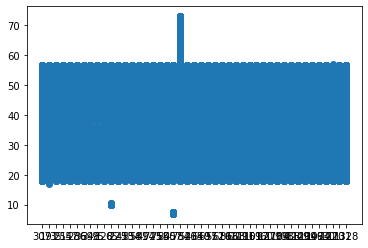

In [3]:
# Range of the values for each file
plt.scatter( df['name'], df['value'])
plt.show()

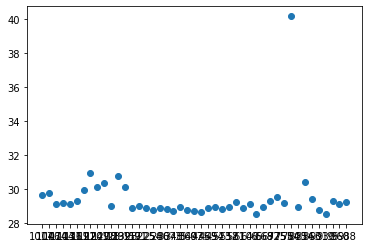

In [4]:
# file level - central tendency measures
df_cluster = df[['name', 'value']].groupby(['name']).mean()
df_cluster['min'] = df[['name', 'value']].groupby(['name']).min()
df_cluster['max'] = df[['name', 'value']].groupby(['name']).max()
df_cluster['median'] = df[['name', 'value']].groupby(['name']).median()
df_cluster['count'] = df[['name', 'value']].groupby(['name']).count()
df_cluster['std'] = df[['name', 'value']].groupby(['name']).std() 
df_cluster['var'] = df[['name', 'value']].groupby(['name']).var() 
df_cluster['batch'] = df[['name', 'batch']].groupby(['name']).first() 
df_cluster = df_cluster.reset_index()
df_cluster.head()

plt.scatter( df_cluster['name'], df_cluster['value'])
plt.show()

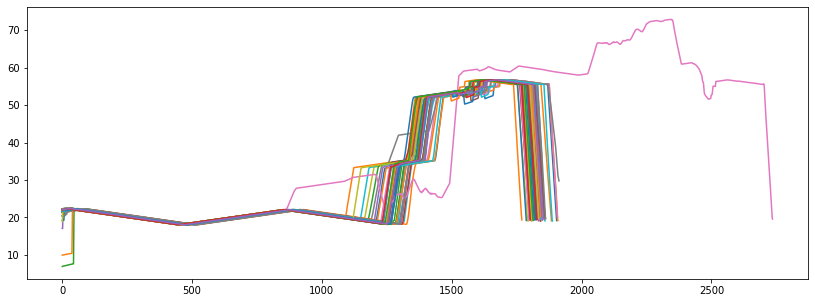

In [5]:
# Printing all files values in one plot
f, ax= plt.subplots(1, 1, sharey=True, figsize=(14,5))
n_names = df_cluster[['name']].to_numpy()

for name in n_names:
    target = name[0]
    n_df = df.query("name == @target")
    plt.plot(n_df['log_order'],n_df['value'], label=target)
    
plt.show()

## Clustering / Outlier Detection

### K-Means

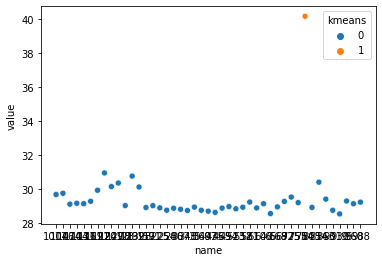

In [6]:
# Clustering - find weird behavior in files
kmeans = KMeans(n_clusters=2).fit(df_cluster[['std', 'value']])
df_cluster['kmeans'] = kmeans.labels_
sns.scatterplot(data=df_cluster, x="name", y="value", hue="kmeans")
plt.show()

#### Using K-Means to cluster the measures in clusters, so the files are comparable in between files (since each file has a different number of measurements)

In [7]:
# clustering values for each file 

# get unique file names 
files = set(df[['name']].to_numpy().flatten())
dfs = []

df_clust = pd.DataFrame()

# apply kmeans to each file
for name in files:
    df_file = df.query("name==@name")
    kmeans = KMeans(n_clusters=10).fit(df_file[['value']])
    k_labels = kmeans.labels_
    k_centers = kmeans.cluster_centers_.flatten()
    df_file['km_label'] = k_labels
    df_file['km_center'] = k_centers[k_labels] # replacing values for its closest centroid
    # df_file_new = df_file[['km_center', 'name', 'log_order']].groupby(['km_center', 'name'], as_index=False).first()
    df_file_new = df_file[['km_center', 'name', 'log_order', 'timestamp' , 'km_label']] \
        .groupby(['km_center', 'name'], as_index=False) \
        .agg({'log_order':'first', 'km_label':'first' , 'timestamp': lambda x: x.max() - x.min()})
    
    df_clust = df_clust.append(df_file_new, ignore_index=True)

df_clust['zero'] = 0       

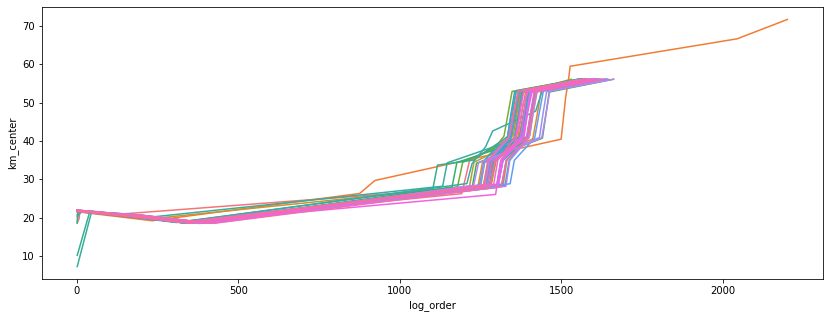

In [8]:
fig, ax = plt.subplots(1,1, figsize=(14,5))
g = sns.lineplot(data=df_clust, x="log_order", y="km_center", hue="name", ax=ax)
g.get_legend().set_visible(False)
plt.show()

In [9]:
# Detecting outliers
#clf = LocalOutlierFactor(n_neighbors=5)
df_out = df_clust[['log_order',  'km_center', 'name']].groupby(["name"]).mean()
df_out['var'] = df_clust[['log_order',  'km_center', 'name']].groupby("name").var()[['km_center']]

df_out['lof'] = clf.fit_predict(df_out[['km_center', 'var']])
fig, ax = plt.subplots(1,1, figsize=(14,5))

outl = df_out#[['log_order',  'km_center']]
g = sns.scatterplot(data=outl, x="name", y="km_center",  hue='lof', ax=ax)
#g.get_legend().set_visible(False)
plt.show()

NameError: name 'clf' is not defined

In [ ]:
outliers_lof = df_out.query("lof == -1")
outliers_lof = outliers_lof.reset_index()
print(outliers_lof)

In [ ]:
names = outliers_lof[['name']].to_numpy().flatten()
my_df = df_clust.query('name in @names')
fig, ax = plt.subplots(1,1, figsize=(14,5))
g = sns.lineplot(data=my_df, x="log_order", y="km_center", hue="name", ax=ax)
#g.get_legend().set_visible(False)
plt.show()

### DBSCAN

In [ ]:
clustering = DBSCAN(min_samples=4).fit(df_cluster[['std',  'value']])
df_cluster['dbscan'] =  clustering.labels_

fig, ax =plt.subplots(1,2, figsize=(14,5))
sns.scatterplot(data=df_cluster, x="value", y="std", hue="dbscan", ax=ax[0])
sns.scatterplot(data=df_cluster, x="name", y="value", hue="dbscan", ax=ax[1])
plt.show()


### Outlier detection

In [ ]:
clf = LocalOutlierFactor(n_neighbors=5)
df_cluster['lof'] = clf.fit_predict(df_cluster[['value',  'std', 'median']])
sns.scatterplot(data=df_cluster, x="name", y="value", hue="lof")

In [ ]:
# Showing outlierst statistics 
outliers = df_cluster.query("(dbscan == -1) or (lof == -1)")
outliers.head()

In [ ]:
o_files = outliers[['name']].to_numpy()
f, ax= plt.subplots(1, 1, sharey=True, figsize=(14,5))
# Plot together
for name, ax in zip(o_files, axes):
    target = name[0]
    o_df = df.query("name == @target")
    print("Name:", target, " MinVal: ", o_df['value'].min(), " MaxVal: ", o_df['value'].max())
    plt.plot(o_df['log_order'], o_df['value'], label=target)
plt.legend()
plt.show()

In [ ]:
# Printing all non-outliers
n_df = pd.concat([df_cluster, outliers]).drop_duplicates(keep=False)
size = len(df)

n_names = n_df[['name']].to_numpy()

for name in n_names:
    target = name[0]
    n_df = df.query("name == @target")
    #print("Name:", target, " MinVal: ", n_df['value'].min(), " MaxVal: ", n_df['value'].max())
    plt.plot(n_df['log_order'],n_df['value'], label=target)
    
plt.show()


# Time series clustering approach

Used toolkit: [tslearn - GitHub](https://github.com/tslearn-team/tslearn)

In [10]:
# Don't know whether it makes sense to drop certain mesaurements that seem to be outliers, e.g. those above 55 or below 15 or similar.
#data = df.query('value >= 10 and value <= 100')
data = df

# Group the measurements based on the process instance id
instance_measurements = df.groupby('instance')

### Setting up the tslearn dataset

In [12]:
from tslearn.utils import to_time_series_dataset

data_array = instance_measurements['value'].apply(pd.Series.tolist).tolist()
X = to_time_series_dataset(data_array)

Resample to reduce size of time series

In [48]:
from tslearn.preprocessing import TimeSeriesResampler

sz = 1000
X = TimeSeriesResampler(sz=sz).fit_transform(X)

In [49]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 6
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=3)
y_pred = model.fit_predict(X)

Plotting predictions

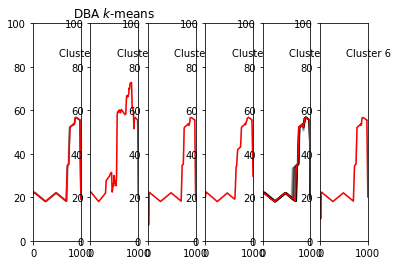

In [50]:
for yi in range(n_clusters):
    plt.subplot(1, n_clusters, 1 + yi)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 100)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

In [51]:
names = instance_measurements['name'].apply(lambda x: x[:1]).tolist()
results = {'name': names, 'instance': instance_measurements.groups.keys(), 'cluster': y_pred}
df_res = pd.DataFrame(results)

In [52]:
df_res

name                              instance  cluster
0    225  026879a0-34a1-4429-81e9-38864d6d2d87        0
1   1191  08bd2d1a-be7e-4e10-b77c-aa83c80d47d8        4
2     95  09f14722-5c65-4b42-b1a5-33c5f5afd92b        0
3     65  0adb8008-3f34-4d6f-83a4-358e4f02d182        5
4   1278  153a7074-638f-4d20-9833-72ce80fa94b1        4
5    755  15f9eecd-5637-44f3-b8fd-9cdf096ed883        4
6   1017  18670576-f00a-4158-a3d0-0c40aa9cab0a        4
7    960  1af4ba9d-66d4-4c40-bced-34d5f18b0438        4
8    369  1c30fc46-76bd-4eb8-a751-664c3857c9d6        4
9    254  26c83dc1-c49e-4822-bd21-1ca7302ab3ae        4
10   128  31aaa99c-930c-47b4-823b-b6364fe1c6ec        0
11   901  3de99ab2-5452-4a01-b9f6-b5fa3ea99b51        4
12  1220  40444042-6deb-4152-b731-2a37660464a5        3
13   494  41c14597-7493-4885-a6ef-318b897076dd        4
14   552  42d65824-fc58-48b0-b9d5-1a9d9152a8bb        4
15  1328  4664b149-4f17-446f-a466-e2c0de3aac54        4
16  1046  4e7e3e41-4fb1-40bc-a850-76f1302618a0        4
17   407  4e973907-a4b2-4c00-9a7e-7ff5f00eadc5        2
18   930  5ecbef3b-f23a-4092-82b3-2bbd785daaee        4
19  1299  6889ff0d-2128-412b-a5ba-6cd842ae625e        4
20    35  694eba1e-d9ae-4b85-b38d-f5d6b506c854        4
21   435  74795358-cde2-49ed-8c4d-ea5302588fba        0
22   640  82a9d51f-4590-4cee-b52c-e0f27a1f67b5        4
23  1074  82edbd65-fd74-4530-b5b0-b25eb616d57c        4
24   610  891ed211-1d31-487f-bef6-6f49d3236563        4
25   697  8eb84228-b900-4c77-bc1b-590fee2b5319        4
26   834  8f9ffa77-d367-4715-8ad5-7f033713b479        4
27  1249  917931b4-191b-4e57-87fc-946bba4659a9        4
28   191  99ed5e9d-e654-44cb-a0a4-36235cb69e3e        4
29   307  9b4a5166-f984-4e98-a0d6-1bd70878b975        0
30  1131  ac90595c-ac77-4755-a6d4-e1e8e5047a4a        4
31   286  ae034340-df2d-4b21-9e7f-909b8759d4c7        0
32   581  af7e2dd7-d22a-4af1-9a1c-401f0132fc97        4
33   348  b0ba35b0-14fe-4080-97d3-b8b6160c2b61        4
34   725  b3e30ffd-1bc4-48cb-bf1f-9235425c1449        4
35   863  bd3ebf8d-d8b9-4b34-9c0e-62831f1db68a        4
36   988  c22e56e9-fcad-4057-96c0-edbf231e5a3e        4
37   805  c8c3ec28-182c-4fb0-838d-034f0660cbac        4
38   668  cf1e759d-709a-43ae-ad1e-d73d47b708d0        4
39  1161  d39fb090-8ae4-4340-809d-2e2a84e30029        4
40   465  ddf9c9eb-05c7-4e6c-a028-2a6ae7546eec        4
41  1104  e40fbb77-15d5-4db2-9fea-6851d830e460        4
42   523  e8de24bb-833a-486a-90ad-cb4abed22615        4
43   157  ef70f227-5e6e-487d-bd12-acf0a36fd2da        4
44   784  fac9e4a3-9e3a-467c-8d1c-9c398186ced4        1

<AxesSubplot:ylabel='Frequency'>

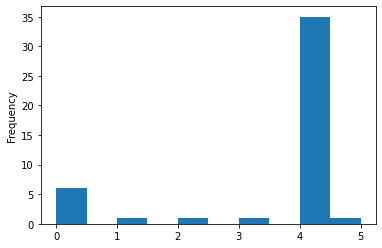

In [53]:
df_res['cluster'].plot(kind='hist')

In [54]:
df_res.query('cluster != 4')

name                              instance  cluster
0    225  026879a0-34a1-4429-81e9-38864d6d2d87        0
2     95  09f14722-5c65-4b42-b1a5-33c5f5afd92b        0
3     65  0adb8008-3f34-4d6f-83a4-358e4f02d182        5
10   128  31aaa99c-930c-47b4-823b-b6364fe1c6ec        0
12  1220  40444042-6deb-4152-b731-2a37660464a5        3
17   407  4e973907-a4b2-4c00-9a7e-7ff5f00eadc5        2
21   435  74795358-cde2-49ed-8c4d-ea5302588fba        0
29   307  9b4a5166-f984-4e98-a0d6-1bd70878b975        0
31   286  ae034340-df2d-4b21-9e7f-909b8759d4c7        0
44   784  fac9e4a3-9e3a-467c-8d1c-9c398186ced4        1

## Quality measure
Since I'm not really sure about how to interpret the measurements, I would suggest to take the sum of squared losses for each measurement in a series based on the cluster centroid.

In [64]:
# Take the centroid as reference
expected = model.cluster_centers_[4].ravel()

# Get good rooks
indices = df_res.index[df_res['cluster'] == 4].tolist()
series = X[indices]

In [65]:
from sklearn.metrics import mean_squared_error

# Calculate losses
losses = [mean_squared_error(x, expected) for x in series]
# Normalize
normalized_losses = [(x-min(losses))/(max(losses)-min(losses)) for x in losses]

# Define quality score as 1 - normalized_loss
quality_score = [1 - x for x in normalized_losses]

In [66]:
# Setting quality score for bad rooks to -1
indices = np.where(df_res.cluster != 4)
for x in indices[0]:
    quality_score.insert(x, -1)

df_res['quality_score'] = quality_score

In [68]:
df_res.head(10)

name                              instance  cluster  quality_score
0   225  026879a0-34a1-4429-81e9-38864d6d2d87        0      -1.000000
1  1191  08bd2d1a-be7e-4e10-b77c-aa83c80d47d8        4       0.577839
2    95  09f14722-5c65-4b42-b1a5-33c5f5afd92b        0      -1.000000
3    65  0adb8008-3f34-4d6f-83a4-358e4f02d182        5      -1.000000
4  1278  153a7074-638f-4d20-9833-72ce80fa94b1        4       0.278812
5   755  15f9eecd-5637-44f3-b8fd-9cdf096ed883        4       0.896565
6  1017  18670576-f00a-4158-a3d0-0c40aa9cab0a        4       0.336206
7   960  1af4ba9d-66d4-4c40-bced-34d5f18b0438        4       0.843058
8   369  1c30fc46-76bd-4eb8-a751-664c3857c9d6        4       0.671068
9   254  26c83dc1-c49e-4822-bd21-1ca7302ab3ae        4       0.703847

In [23]:
from anytree.importer import JsonImporter

importer = JsonImporter()
with open("loganalysis/log_structure_with_processnames_batch07_bus.json", 'r') as file:

    root = importer.import_(file.read())

In [24]:
from anytree.search import findall

parent_processes = []
keyence_processes = []
parents = findall(root, filter_=lambda node: node.processname == "Spawn Turm Production")
for parent in parents:
    parent_processes.append(parent.id)
    child = findall(parent, filter_=lambda node: node.processname == "Turm Keyence Measuring")[0]
    keyence_processes.append(child.id)

lookup = pd.DataFrame(list(zip(parent_processes, keyence_processes)), columns = ['Parent', 'Keyence'])

In [25]:
lookup

Parent                               Keyence
0   92f1622b-f6c5-4025-ad12-2a5dfb86912e  694eba1e-d9ae-4b85-b38d-f5d6b506c854
1   f9838fc0-6c08-4923-bd1d-bcb53fd61e25  0adb8008-3f34-4d6f-83a4-358e4f02d182
2   be48090f-5fe8-439b-b200-3ddb76b44fc2  09f14722-5c65-4b42-b1a5-33c5f5afd92b
3   576692a2-749a-472c-8933-b6513a5e0d25  31aaa99c-930c-47b4-823b-b6364fe1c6ec
4   52852e1c-7052-410c-9813-08a109900b32  ef70f227-5e6e-487d-bd12-acf0a36fd2da
5   d3bcbf36-90e5-40a1-8c06-43d38b8341bb  99ed5e9d-e654-44cb-a0a4-36235cb69e3e
6   2f1932fa-df49-4ce5-8afe-1bfbcd94f6ff  026879a0-34a1-4429-81e9-38864d6d2d87
7   011c2ecc-b97e-4ef0-9067-e189aaaa01d4  26c83dc1-c49e-4822-bd21-1ca7302ab3ae
8   04a25a68-7e23-47b3-bafd-c904b058cee8  ae034340-df2d-4b21-9e7f-909b8759d4c7
9   e96864ce-81d4-4f87-8fd3-a1a4c746e8cc  9b4a5166-f984-4e98-a0d6-1bd70878b975
10  366ace20-ff87-4d6a-ac89-2f73321ee794  b0ba35b0-14fe-4080-97d3-b8b6160c2b61
11  3f68da66-be30-4c4d-afb2-afc627ab73a4  1c30fc46-76bd-4eb8-a751-664c3857c9d6